In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import Fluka_dump_tools as fdt


In [2]:
N_files = 50
Energy = 3740
Rseed = 1

fluka_dir = '/Users/mghrear/Lab/HPS/fluka/'+str(Energy)+'MeV_userdump_s'+str(Rseed)+'/'

In [3]:
# Convert fluka dump files into pandas dataframes
fdt.FlukaDump_toPandas(fluka_dir, N_files, Energy)

#loop through saved pkl files and append them to a single DataFrame
df = pd.DataFrame()
for i in np.arange(1,N_files+1,1):
    i = str(i).zfill(3)
    file_name = fluka_dir+"phiKK_"+str(Energy)+ i + ".pkl"
    temp_df = pd.read_pickle(file_name)
    df = pd.concat([df, temp_df], ignore_index=True)
df.head()

,ProjID,ProjkE,ProjdirX,ProjdirY,ProjdirZ,Gen_No,IntID,NoSecondary,IDs,Ps,Xs,Ys,Zs
0,7,3.363326,-0.000027,-0.000457,1.0,2,101,4,"[8, 16, 15, 7]","[2.0863241346933203, 1.3959766266633853, 0.181...","[0.20282054899916518, -0.3893057108339896, 0.7...","[0.017216074199942085, -0.06061276473970396, 0...","[0.9790645697260315, 0.9191121565198946, -0.25..."
1,7,3.450865,-0.000203,0.000725,1.0,2,101,35,"[16, 15, 8, 1, 1, 8, 8, 1, 8, 8, 8, 8, 8, 1, 8...","[0.6508387294814963, 0.1807570242980634, 1.064...","[0.70690644679263, 0.5083894583643068, -0.4823...","[0.2443602653654536, -0.30839783505905133, 0.6...","[0.6637554792192254, 0.8040092872317688, 0.575..."
2,7,3.249103,0.000220,-0.000419,1.0,2,101,23,"[16, 15, 13, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...","[0.4692945871216088, 0.9553241173577816, 0.337...","[-0.6240857354628896, 0.5391874724649572, 0.71...","[0.7348041227748018, -0.4408279534772031, 0.69...","[0.26566877111338877, 0.7175984845092357, 0.03..."
3,7,3.440547,-0.000082,0.000113,1.0,2,101,12,"[16, 1, 15, 1, 8, 8, 8, 8, 8, 8, 8, 7]","[1.8321739850382024, 1.2791127581238353, 0.545...","[0.0032125559323020704, 0.06758609404678512, -...","[-0.19374192630578702, -0.37186128179242744, 0...","[0.9810472697458084, 0.9258246632031315, 0.384..."
4,7,3.733681,0.000085,0.000229,1.0,2,101,10,"[8, 13, 16, 15, 8, 8, 8, 8, 8, 8]","[0.6783147735316747, 0.5770923070076501, 1.150...","[-0.42645305886079027, -0.32587806456087137, 0...","[-0.5278888128642256, 0.15314610847421256, 0.2...","[0.7344870249644128, 0.9329253756315481, 0.936..."


In [4]:
# Keep only 2nd gen events, starting with a photon, with one K+ and one K- secondaries
df['Kflag'] = df.IDs.apply(lambda x: np.count_nonzero(x == 16) == 1)
df['Kflag2'] = df.IDs.apply(lambda x: np.count_nonzero(x == 15) == 1)
df_phiKK = df.loc[(df.Kflag == True)&(df.Kflag2 == True) &(df.Gen_No == 2)&(df.ProjID == 7)  ].reset_index(drop=True)


In [5]:
# mass of kaon
mK = 0.493677

# Get the momentum and energy of the kaons
df_phiKK['PKm'] = df_phiKK.apply(lambda row: np.array([row.Xs[row.IDs == 16].item(),row.Ys[row.IDs == 16].item(),row.Zs[row.IDs == 16].item()])*row.Ps[row.IDs == 16].item() , axis=1)
df_phiKK['PKp'] = df_phiKK.apply(lambda row: np.array([row.Xs[row.IDs == 15].item(),row.Ys[row.IDs == 15].item(),row.Zs[row.IDs == 15].item()])*row.Ps[row.IDs == 15].item() , axis=1)
df_phiKK['EKm'] = df_phiKK.apply(lambda row: mK/np.sqrt(1-( row.Ps[row.IDs == 16].item()**2 / ( mK**2 + row.Ps[row.IDs == 16].item()**2 ) )) , axis=1)
df_phiKK['EKp'] = df_phiKK.apply(lambda row: mK/np.sqrt(1-( row.Ps[row.IDs == 15].item()**2 / ( mK**2 + row.Ps[row.IDs == 15].item()**2 ) )) , axis=1)

# Calculate the invariant mass 
df_phiKK['M']= df_phiKK.apply(lambda row: np.sqrt((row.EKp+row.EKm)**2 - (row.PKm+row.PKp).dot(row.PKm+row.PKp)) , axis=1)



Text(0, 0.5, 'Counts')

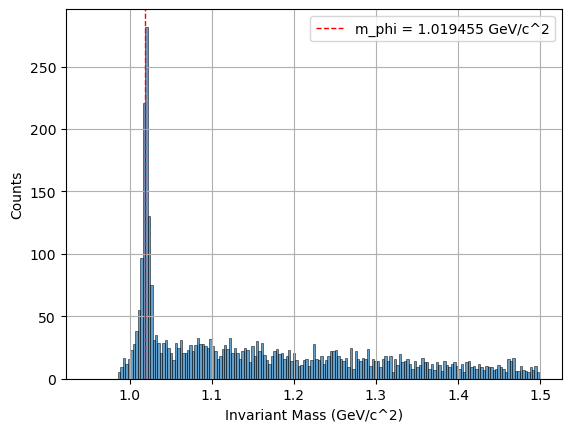

In [6]:
# mass of the phi meson
m_phi = 1.019455

df_phiKK.M.hist(bins=np.arange(0.95, 1.5, 0.003), edgecolor='black', linewidth=0.5, alpha=0.7)
plt.axvline(m_phi, color='red', linestyle='dashed', linewidth=1, label='m_phi = 1.019455 GeV/c^2')
plt.legend()
plt.xlabel("Invariant Mass (GeV/c^2)")
plt.ylabel("Counts") 


Text(0, 0.5, 'Counts')

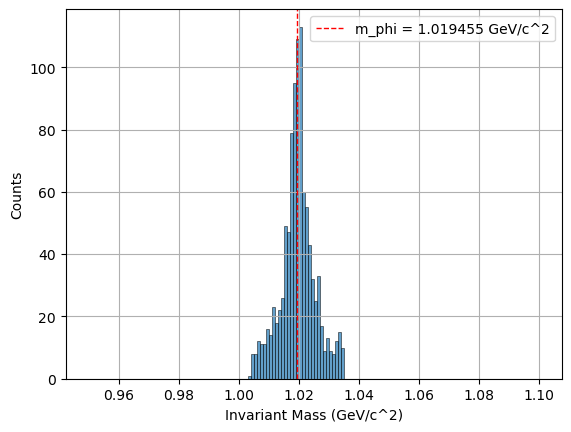

In [7]:
df_phiKK_cut = df_phiKK.loc[(df_phiKK.M > 1.00391) & (df_phiKK.M < 1.035)].reset_index(drop=True)

df_phiKK_cut.M.hist(bins=np.arange(0.95, 1.1, 0.001), edgecolor='black', linewidth=0.5, alpha=0.7)
plt.axvline(m_phi, color='red', linestyle='dashed', linewidth=1, label='m_phi = 1.019455 GeV/c^2')
plt.legend()
plt.xlabel("Invariant Mass (GeV/c^2)")
plt.ylabel("Counts") 

In [8]:
df_phiKK_cut["PPhi"]=df_phiKK_cut.apply(lambda row: row.PKm+row.PKp, axis=1)
df_phiKK_cut["EPhi"]=df_phiKK_cut.apply(lambda row: row.EKm+row.EKp, axis=1)

Text(0, 0.5, 'counts')

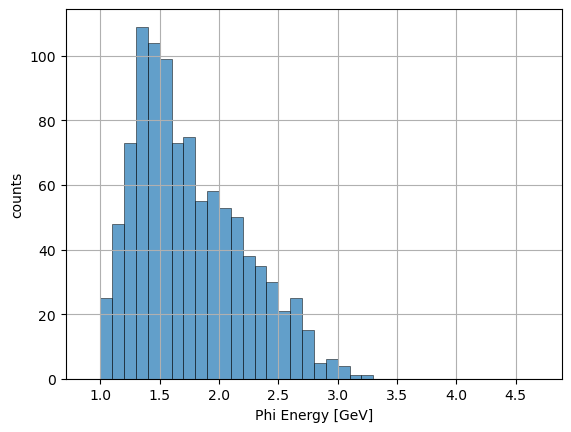

In [9]:
df_phiKK_cut.EPhi.hist(bins =  np.arange(0.9,4.8,0.1), edgecolor='black', linewidth=0.5, alpha=0.7)
plt.xlabel("Phi Energy [GeV]")
plt.ylabel("counts")

In [10]:
# Get first entry of each array in df_phiKK_cut.PKm
df_phiKK_cut['PKm_x'] = df_phiKK_cut.PKm.apply(lambda x: x[0])
df_phiKK_cut['PKm_y'] = df_phiKK_cut.PKm.apply(lambda x: x[1])
df_phiKK_cut['PKm_z'] = df_phiKK_cut.PKm.apply(lambda x: x[2])
df_phiKK_cut['PKp_x'] = df_phiKK_cut.PKp.apply(lambda x: x[0])
df_phiKK_cut['PKp_y'] = df_phiKK_cut.PKp.apply(lambda x: x[1])
df_phiKK_cut['PKp_z'] = df_phiKK_cut.PKp.apply(lambda x: x[2])


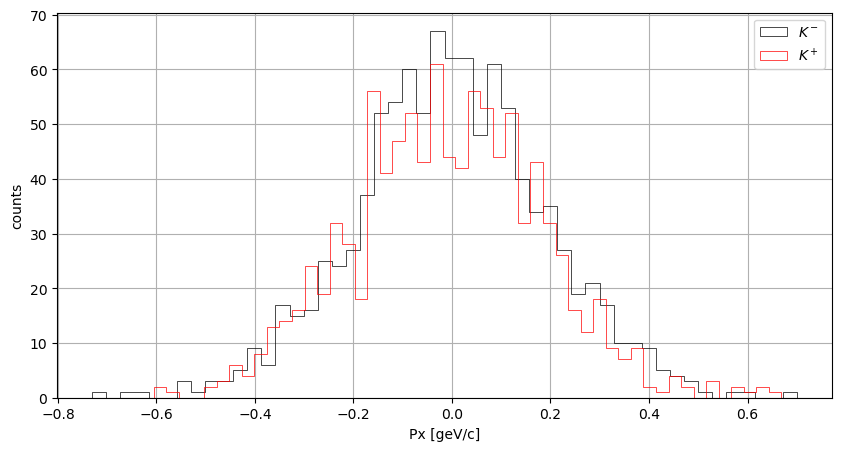

In [11]:
# Make histogram of PKm_x and PKp_x
plt.figure(figsize=(10, 5))
plt.hist(df_phiKK_cut['PKm_x'], bins=50, histtype="step", label='$K^-$', edgecolor='black', linewidth=0.5)
plt.hist(df_phiKK_cut['PKp_x'], bins=50, histtype="step", label='$K^+$', edgecolor='Red', linewidth=0.5)
plt.grid()
plt.xlabel('Px [geV/c]')
plt.ylabel("counts")
plt.legend()

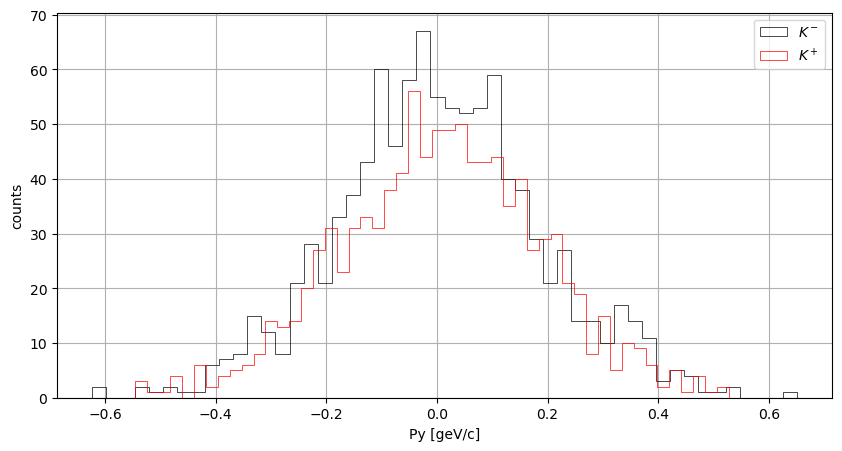

In [12]:
plt.figure(figsize=(10, 5))
plt.hist(df_phiKK_cut['PKm_y'], bins=50, histtype="step", label='$K^-$', edgecolor='black', linewidth=0.5)
plt.hist(df_phiKK_cut['PKp_y'], bins=50, histtype="step", label='$K^+$', edgecolor='Red', linewidth=0.5)
plt.grid()
plt.xlabel('Py [geV/c]')
plt.ylabel("counts")
plt.legend()

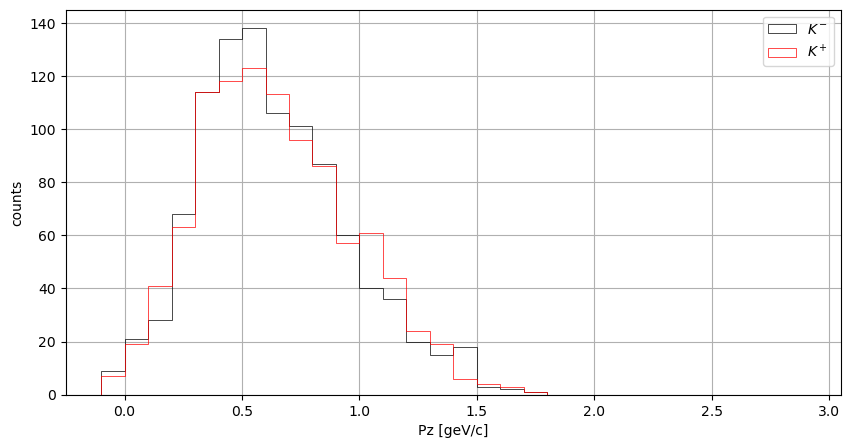

In [13]:
# Make histogram of PKm_x and PKp_x
plt.figure(figsize=(10, 5))
plt.hist(df_phiKK_cut['PKm_z'], bins=np.arange(-0.1,3.0,0.1), histtype="step", label='$K^-$', edgecolor='black', linewidth=0.5)
plt.hist(df_phiKK_cut['PKp_z'], bins=np.arange(-0.1,3.0,0.1), histtype="step", label='$K^+$', edgecolor='Red', linewidth=0.5)
plt.grid()
plt.xlabel('Pz [geV/c]')
plt.ylabel("counts")
plt.legend()

In [14]:
df_phiKK_cut_2sec = df_phiKK_cut.loc[ df_phiKK_cut.NoSecondary == 2 ].reset_index(drop=True)

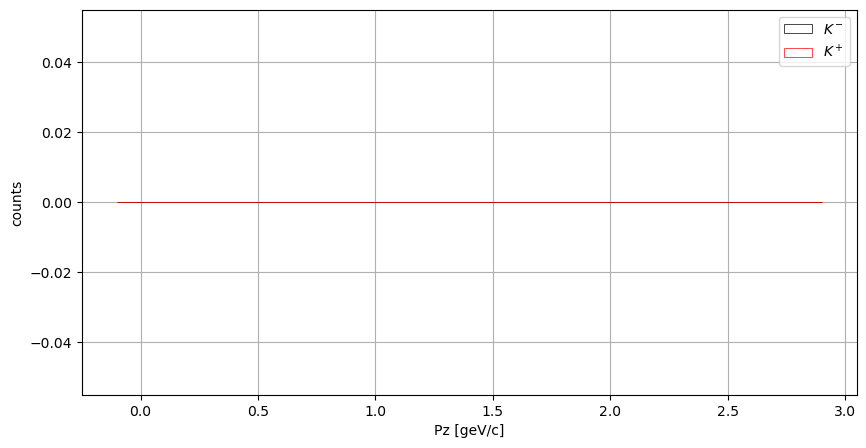

In [15]:
# Make histogram of PKm_x and PKp_x
plt.figure(figsize=(10, 5))
plt.hist(df_phiKK_cut_2sec['PKm_z'], bins=np.arange(-0.1,3.0,0.1), histtype="step", label='$K^-$', edgecolor='black', linewidth=0.5)
plt.hist(df_phiKK_cut_2sec['PKp_z'], bins=np.arange(-0.1,3.0,0.1), histtype="step", label='$K^+$', edgecolor='Red', linewidth=0.5)
plt.grid()
plt.xlabel('Pz [geV/c]')
plt.ylabel("counts")
plt.legend()

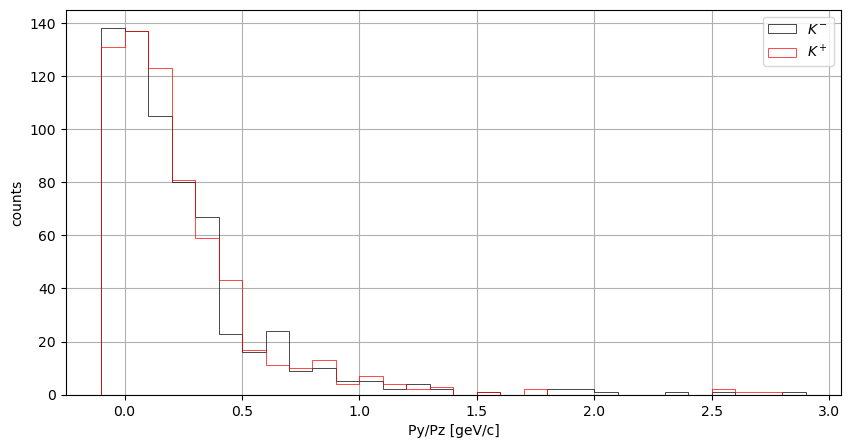

In [16]:
# Make histogram of PKm_x and PKp_x
plt.figure(figsize=(10, 5))
plt.hist(df_phiKK_cut['PKm_y']/df_phiKK_cut['PKm_z'], bins=np.arange(-0.1,3.0,0.1), histtype="step", label='$K^-$', edgecolor='black', linewidth=0.5)
plt.hist(df_phiKK_cut['PKp_y']/df_phiKK_cut['PKp_z'], bins=np.arange(-0.1,3.0,0.1), histtype="step", label='$K^+$', edgecolor='Red', linewidth=0.5)
plt.grid()
plt.xlabel('Py/Pz [geV/c]')
plt.ylabel("counts")
plt.legend()

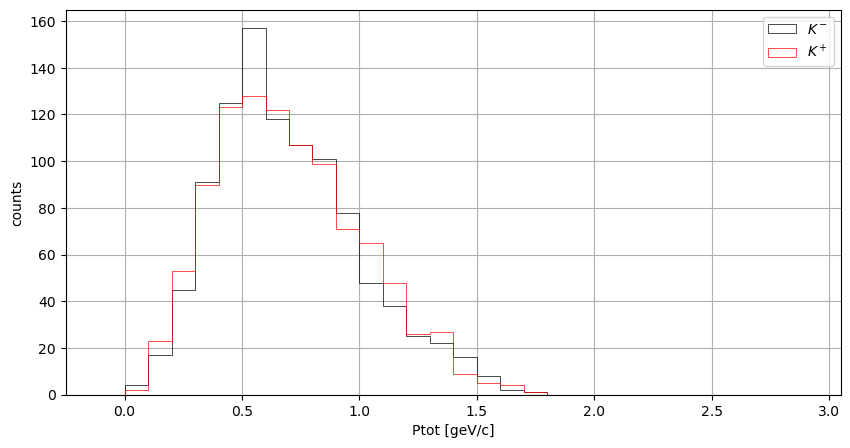

In [17]:
# Make histogram of PKm_x and PKp_x
plt.figure(figsize=(10, 5))
plt.hist(np.sqrt(df_phiKK_cut['PKm_x']**2+df_phiKK_cut['PKm_y']**2+df_phiKK_cut['PKm_z']**2), bins=np.arange(-0.1,3.0,0.1), histtype="step", label='$K^-$', edgecolor='black', linewidth=0.5)
plt.hist(np.sqrt(df_phiKK_cut['PKp_x']**2+df_phiKK_cut['PKp_y']**2+df_phiKK_cut['PKp_z']**2), bins=np.arange(-0.1,3.0,0.1), histtype="step", label='$K^+$', edgecolor='Red', linewidth=0.5)
plt.grid()
plt.xlabel('Ptot [geV/c]')
plt.ylabel("counts")
plt.legend()

In [ ]:
# Make histogram of PKm_x and PKp_x
plt.figure(figsize=(10, 5))
plt.hist(np.sqrt(df_phiKK_cut['PKm_x']**2+df_phiKK_cut['PKm_y']**2+df_phiKK_cut['PKm_z']**2), bins=np.arange(-0.1,3.0,0.1), histtype="step", label='$K^-$', edgecolor='black', linewidth=0.5)
plt.hist(np.sqrt(df_phiKK_cut['PKp_x']**2+df_phiKK_cut['PKp_y']**2+df_phiKK_cut['PKp_z']**2), bins=np.arange(-0.1,3.0,0.1), histtype="step", label='$K^+$', edgecolor='Red', linewidth=0.5)
plt.grid()
plt.xlabel('Ptot [geV/c]')
plt.ylabel("counts")
plt.legend()

Text(0, 0.5, 'counts')

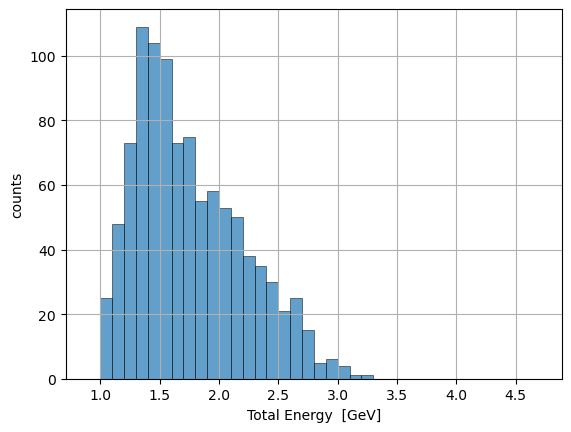

In [21]:
(df_phiKK_cut.EKp + df_phiKK_cut.EKm).hist(bins=np.arange(0.9,4.8,0.1), edgecolor='black', linewidth=0.5, alpha=0.7)
plt.xlabel("Total Energy  [GeV]")
plt.ylabel("counts")